## Creating artifical data

We can use $\mu + \sigma$ `scipy.stats.norm.rvs()` to create random values of a normal distribution. This would result in a perfect line.

To further add normal distributed (Gaussian) noise, we add $\alpha$ times `scipy.stats.norm.rvs()`:

$\mu + \sigma$ `scipy.stats.norm.rvs()` + $\alpha$ `scipy.stats.norm.rvs()`

This results in a Datenwolke.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

import seaborn as sns
sns.set(style="white")



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


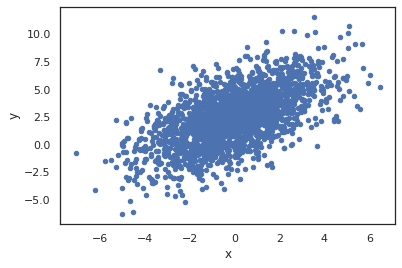

In [2]:
df = pd.DataFrame(columns=['x','y'])

X = 2*scipy.stats.norm.rvs(size=2000)
#Only part of the variance of Y can be explained by X:
Y = 2.5 + 0.75*X + 2*scipy.stats.norm.rvs(size=2000)

df['x']=X
df['y']=Y

df.plot.scatter(x='x', y='y')

## Manual OLS with pandas

We want to find a regression model $f(X) = \beta_0 + \beta_1 * X$ with intercept $\beta_0$ and slope $\beta_1$.

We want this model to be as close to the true label $Y$ as possible, i.e. $Y + \epsilon = f(X)$, where $\epsilon$ is the errorterm/offset. We want to minimize the squared errors:
$ \sum_{i=1}^n \epsilon^2 = \sum_{i=1}^n (y_i - \hat{y}_i)^2$, where $\hat{y}$ is the prediction $f(x_i)$.

We can manually calculate the parameters for a linear regression:

Slope estimate: $ \hat{\beta}_1 = \dfrac{\sum_{i=1}^n (x_i - \bar{x}) (y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2}$

Intercept estimate: $\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}$,

where $\bar{x}, \bar{y}$ are the sample means. 



In [3]:
x_mean = df['x'].mean()
y_mean = df['y'].mean()

beta_1 = sum( (X-x_mean)*(Y-y_mean) ) / sum( np.power(X-x_mean,2))

beta_0 = y_mean - beta_1*x_mean

print(beta_0, beta_1)

2.5067688414097526 0.7530227987735636


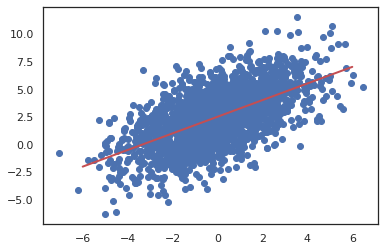

In [4]:
import matplotlib.pyplot as plt


x_line = np.linspace(-6,6,100)
y_line = beta_0 + beta_1 * x_line

plt.scatter(X,Y)
plt.plot(x_line, y_line, c='r', lw=2)

## Manual OLS with seaborn

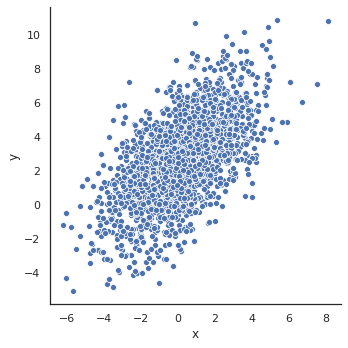

In [18]:
X = 2*scipy.stats.norm.rvs(size=2000)
#Only part of the variance of Y can be explained by X:
Y = 2.5 + 0.75*X + 2*scipy.stats.norm.rvs(size=2000)

df = pd.DataFrame({'x': X,'y': Y})

sns.relplot(x='x', y='y', data=df)

In [19]:
x_mean = df['x'].mean()
y_mean = df['y'].mean()

beta_1 = np.sum( (df['x']-x_mean)*(df['y']-y_mean) ) / np.sum( (df['x']-x_mean)**2)

beta_0 = y_mean - beta_1*x_mean

print(beta_0, beta_1)

2.5307400113798555 0.7433048406233201


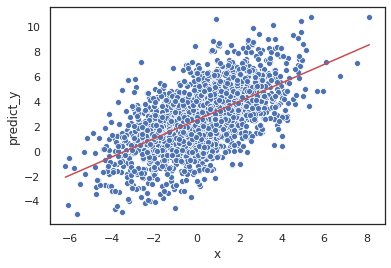

In [20]:
df['predict_y'] = beta_0 + beta_1 * df['x']

sns.scatterplot(x='x', y='y', data=df)
sns.lineplot(x='x', y='predict_y', data=df, color='r')

## OLS with sklearn

`sklearn` is one of the most popular machine learning packages and is basically a one-stop-shop for data science.

We can use the `LinearRegression()` class and the `fit()` function to create a linear regression automatically. 

Note: `fit()` requires whole dataframes as inputs *or* real numpy values. This is because this class also supports multivariate linear regression.

In [8]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(df[['x']], df[['y']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We can access the fitted slope by using `coef_` and the fitted intercept by using `intercept_`.

In [9]:
print(model.coef_[0][0])
print(model.intercept_[0])

0.7344411554389881
2.458834931520141


We can use `predict()` to pass a new value and predict its corresponding y-value.

Note: `predict()` expects an array as input

In [10]:
print(model.predict([[4]]))
#this should yield the intercept:
print(model.predict([[0]]))

[[5.39659955]]
[[2.45883493]]


We can now draw the predicted data line, by passing the `x`-values to `predict()` as a vector.

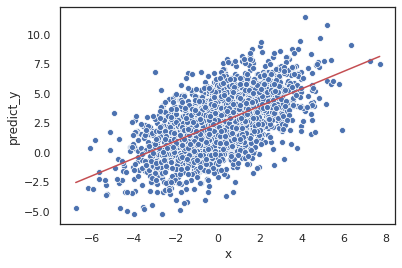

In [11]:
df['predict_y'] = model.predict(df[['x']]).reshape(-1)

sns.scatterplot(x='x', y='y', data=df)
sns.lineplot(x='x', y='predict_y', data=df, color='r')

Alternatively, for a very fast implementation, we can use seaborns `regplot()` for an immediate plot of the data and the corresponding linear regression line.

The shaddy parts around the line show our confidence in the estimated slope (Standard Error).

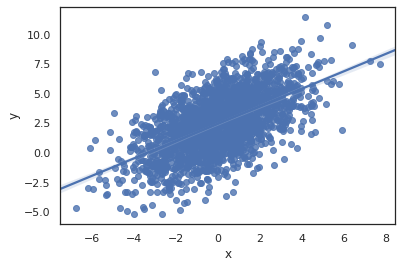

In [12]:
sns.regplot(x='x', y='y', data=df)

## RSS Accuracy

If we want to measure the total loss of the squared errors, then we calculate the `RSS` = $ \sum_{i=1}^n (y_i - \hat{y})^2 $.

Note: the order of $y_i$ and $\hat{y}_i$ doesn't matter.

Disadvantage: depends on sample size $n$ $\Rightarrow$ use `MSE`.

In [26]:
def rss(y, y_hat):
    return np.sum( (y - y_hat)**2 )

In [28]:
rss(df['y'],df['predict_y'])

7834.527604980336

## MSE Accuracy

MSE is an averaged `RSS`, which is independent of the sample size $n$ and defined as `MSE` = $ \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y})^2 $.

Disadvantage: it still depends on the *squared error* units and not on the units of the Y-values.

In [31]:
rss(df['y'],df['predict_y'])/len(df['y'])

3.917263802490168

In sklearn, we can use `metrics.mean_squared_error()` for automatic calculation.

In [34]:
from sklearn import metrics

metrics.mean_squared_error(df['y'],df['predict_y'])


3.917263802490168

## RSE Accuracy

We want to have a measure, that depends on the units of the Y-values. Thats why we use `RSE` = $ \sqrt{ \frac{1}{n-2} \sum_{i=1}^n (y_i - \hat{y})^2 }$.

Note: $\frac{1}{n-2}$ is the Bessel Correcting Term.



In [37]:
np.sqrt(rss(df['y'],df['predict_y'])/(len(df['y'])-2))

1.9801982192390857

## $R^2$ Accuracy

$R^2$ gives a measure that is independent of the sample size and the units in the data, which allows to compare differently generated linear models with eachother.

$R^2$ measures the fraction of variance (Streeung) in the dependent variable (Y) that is explained by our linear model (independent variables vs. dependent variables).

$R^2 = 1 - \frac{\text{RSS}}{\text{TSS}} = \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$

TSS is the total sum of squares, assuming that TSS are the *biggest error squares possible*. We take the error between y and the mean value of y.

In [40]:
1 - rss(df['y'],df['predict_y'])/(np.sum( (df['y'] - df['y'].mean() )**2 ))

0.35769916781605626

In sklearn, we can use `metrics.r2_score()` for automatic calculation.

Note: order of the arguments matters:
`metrics.r2_score(true_y, predicted_y)`

In [41]:
metrics.r2_score(df['y'],df['predict_y'])

0.35769916781605626